In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('max_rows', 300)
pd.set_option('max_columns', 300)

import os
import glob
# data directory
data_dir = '../input/optiver-realized-volatility-prediction/'

# 関数準備

In [2]:
def calc_wap(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1'])/(df['bid_size1'] + df['ask_size1'])
    return wap

def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2'])/(df['bid_size2'] + df['ask_size2'])
    return wap

def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

def count_unique(series):
    return len(np.unique(series))


# Book_Dataの特徴量抽出関数

In [3]:
def preprocessor_book(file_path):
    df = pd.read_parquet(file_path)
    #calculate return etc
    df['wap'] = calc_wap(df)
    df['log_return'] = df.groupby('time_id')['wap'].apply(log_return)
    
    df['wap2'] = calc_wap2(df)
    df['log_return2'] = df.groupby('time_id')['wap2'].apply(log_return)
    
    df['wap_balance'] = abs(df['wap'] - df['wap2'])
    
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1'])/2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))

    #dict for aggregate
    create_feature_dict = {
        'log_return':[realized_volatility],
        'log_return2':[realized_volatility],
        'wap_balance':[np.mean],
        'price_spread':[np.mean],
        'bid_spread':[np.mean],
        'ask_spread':[np.mean],
        'volume_imbalance':[np.mean],
        'total_volume':[np.mean],
        'wap':[np.mean],
            }

    #####groupby / all seconds
    df_feature = pd.DataFrame(df.groupby(['time_id']).agg(create_feature_dict)).reset_index()
    
    df_feature.columns = ['_'.join(col) for col in df_feature.columns] #time_id is changed to time_id_
        
    ######groupby / last XX seconds
    last_seconds = []
    
    for second in last_seconds:
        second = 600 - second 
    
        df_feature_sec = pd.DataFrame(df.query(f'seconds_in_bucket >= {second}').groupby(['time_id']).agg(create_feature_dict)).reset_index()
        df_feature_sec.columns = ['_'.join(col) for col in df_feature_sec.columns] #time_id is changed to time_id_
        df_feature_sec = df_feature_sec.add_suffix('_' + str(second))
        df_feature = pd.merge(df_feature,df_feature_sec,how='left',left_on='time_id_',right_on=f'time_id__{second}')
        df_feature = df_feature.drop([f'time_id__{second}'],axis=1)
    
    #create row_id
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature = df_feature.drop(['time_id_'],axis=1)
    
    return df_feature

# Trade_Dataの特徴量抽出

In [4]:
def preprocessor_trade(file_path):
    df = pd.read_parquet(file_path)
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)
    
    
    aggregate_dictionary = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum],
        'order_count':[np.mean],
    }
    
    df_feature = df.groupby('time_id').agg(aggregate_dictionary)
    
    df_feature = df_feature.reset_index()
    df_feature.columns = ['_'.join(col) for col in df_feature.columns]

    
    ######groupby / last XX seconds
    last_seconds = []
    
    for second in last_seconds:
        second = 600 - second
    
        df_feature_sec = df.query(f'seconds_in_bucket >= {second}').groupby('time_id').agg(aggregate_dictionary)
        df_feature_sec = df_feature_sec.reset_index()
        
        df_feature_sec.columns = ['_'.join(col) for col in df_feature_sec.columns]
        df_feature_sec = df_feature_sec.add_suffix('_' + str(second))
        
        df_feature = pd.merge(df_feature,df_feature_sec,how='left',left_on='time_id_',right_on=f'time_id__{second}')
        df_feature = df_feature.drop([f'time_id__{second}'],axis=1)
    
    df_feature = df_feature.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature = df_feature.drop(['trade_time_id_'],axis=1)
    
    return df_feature

# BookとTradeのデータをJoinする

In [5]:
def preprocessor(list_stock_ids, is_train = True):
    from joblib import Parallel, delayed # parallel computing to save time
    df = pd.DataFrame()
    
    def for_joblib(stock_id):
        if is_train:
            file_path_book = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)
        else:
            file_path_book = data_dir + "book_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_test.parquet/stock_id=" + str(stock_id)
            
        df_tmp = pd.merge(preprocessor_book(file_path_book),preprocessor_trade(file_path_trade),on='row_id',how='left')
     
        return pd.concat([df,df_tmp])
    
    df = Parallel(n_jobs=-1, verbose=1)(
        delayed(for_joblib)(stock_id) for stock_id in list_stock_ids
        )

    df =  pd.concat(df,ignore_index = True)
    return df

# データ
## 学習データ準備

In [6]:
train = pd.read_csv(data_dir + 'train.csv')
train_ids = train.stock_id.unique()

In [7]:
%%time
df_train = preprocessor(list_stock_ids= train_ids, is_train = True)
df_train_temp = df_train

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.9min


CPU times: user 2.69 s, sys: 208 ms, total: 2.89 s
Wall time: 7min 28s


[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  7.5min finished


In [8]:
train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
train = train[['row_id','target']]
df_train = train.merge(df_train_temp, on = ['row_id'], how = 'left')
df_train.head()

,row_id,target,log_return_realized_volatility,log_return2_realized_volatility,wap_balance_mean,price_spread_mean,bid_spread_mean,ask_spread_mean,volume_imbalance_mean,total_volume_mean,wap_mean,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean
0,0-5,0.004136,0.004499,0.006999,0.000388,0.000852,0.000176,-0.000151,134.894040,323.496689,1.003725,0.002006,40.0,3179.0,2.750000
1,0-11,0.001445,0.001204,0.002476,0.000212,0.000394,0.000142,-0.000135,142.050000,411.450000,1.000239,0.000901,30.0,1289.0,1.900000
2,0-16,0.002168,0.002369,0.004801,0.000331,0.000725,0.000197,-0.000198,141.414894,416.351064,0.999542,0.001961,25.0,2161.0,2.720000
3,0-31,0.002195,0.002574,0.003637,0.000380,0.000860,0.000190,-0.000108,146.216667,435.266667,0.998832,0.001561,15.0,1962.0,3.933333
4,0-62,0.001747,0.001894,0.003257,0.000254,0.000397,0.000191,-0.000109,123.846591,343.221591,0.999619,0.000871,22.0,1791.0,4.045455


## テストデータ準備

In [9]:
test = pd.read_csv(data_dir + 'test.csv')
test_ids = test.stock_id.unique()

In [10]:
%%time
df_test = preprocessor(list_stock_ids= test_ids, is_train = False)
df_test_temp = df_test

CPU times: user 17.8 ms, sys: 1.08 ms, total: 18.9 ms
Wall time: 107 ms


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


In [11]:
df_test = test.merge(df_test, on = ['row_id'], how = 'left')
df_test.head()

,stock_id,time_id,row_id,log_return_realized_volatility,log_return2_realized_volatility,wap_balance_mean,price_spread_mean,bid_spread_mean,ask_spread_mean,volume_imbalance_mean,total_volume_mean,wap_mean,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean
0,0,4,0-4,0.000294,0.000252,0.000145,0.000557,0.000393,-0.000115,164.666667,350.666667,1.000405,0.000295,3.0,201.0,3.666667
1,0,32,0-32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,34,0-34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
from sklearn.model_selection import KFold
#stock_id target encoding
df_train['stock_id'] = df_train['row_id'].apply(lambda x:x.split('-')[0])
df_test['stock_id'] = df_test['row_id'].apply(lambda x:x.split('-')[0])

stock_id_target_mean = df_train.groupby('stock_id')['target'].mean() 
df_test['stock_id_target_enc'] = df_test['stock_id'].map(stock_id_target_mean) # test_set

#training
tmp = np.repeat(np.nan, df_train.shape[0])
kf = KFold(n_splits = 10, shuffle=True,random_state = 19911109)
for idx_1, idx_2 in kf.split(df_train):
    target_mean = df_train.iloc[idx_1].groupby('stock_id')['target'].mean()

    tmp[idx_2] = df_train['stock_id'].iloc[idx_2].map(target_mean)
df_train['stock_id_target_enc'] = tmp

# Model Building

In [13]:
df_train.head()

,row_id,target,log_return_realized_volatility,log_return2_realized_volatility,wap_balance_mean,price_spread_mean,bid_spread_mean,ask_spread_mean,volume_imbalance_mean,total_volume_mean,wap_mean,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,stock_id,stock_id_target_enc
0,0-5,0.004136,0.004499,0.006999,0.000388,0.000852,0.000176,-0.000151,134.894040,323.496689,1.003725,0.002006,40.0,3179.0,2.750000,0,0.004041
1,0-11,0.001445,0.001204,0.002476,0.000212,0.000394,0.000142,-0.000135,142.050000,411.450000,1.000239,0.000901,30.0,1289.0,1.900000,0,0.004039
2,0-16,0.002168,0.002369,0.004801,0.000331,0.000725,0.000197,-0.000198,141.414894,416.351064,0.999542,0.001961,25.0,2161.0,2.720000,0,0.004041
3,0-31,0.002195,0.002574,0.003637,0.000380,0.000860,0.000190,-0.000108,146.216667,435.266667,0.998832,0.001561,15.0,1962.0,3.933333,0,0.004013
4,0-62,0.001747,0.001894,0.003257,0.000254,0.000397,0.000191,-0.000109,123.846591,343.221591,0.999619,0.000871,22.0,1791.0,4.045455,0,0.004032


In [14]:
df_test.head()

,stock_id,time_id,row_id,log_return_realized_volatility,log_return2_realized_volatility,wap_balance_mean,price_spread_mean,bid_spread_mean,ask_spread_mean,volume_imbalance_mean,total_volume_mean,wap_mean,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,stock_id_target_enc
0,0,4,0-4,0.000294,0.000252,0.000145,0.000557,0.000393,-0.000115,164.666667,350.666667,1.000405,0.000295,3.0,201.0,3.666667,0.004028
1,0,32,0-32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004028
2,0,34,0-34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004028


In [15]:
DO_FEAT_IMP = False
if len(df_test)==3:
    DO_FEAT_IMP = True

# LightGBM

In [16]:
import lightgbm as lgbm

In [17]:
# ref https://www.kaggle.com/corochann/permutation-importance-for-feature-selection-part1
def calc_model_importance(model, feature_names=None, importance_type='gain'):
    importance_df = pd.DataFrame(model.feature_importance(importance_type=importance_type),
                                 index=feature_names,
                                 columns=['importance']).sort_values('importance')
    return importance_df


def plot_importance(importance_df, title='',
                    save_filepath=None, figsize=(8, 12)):
    fig, ax = plt.subplots(figsize=figsize)
    importance_df.plot.barh(ax=ax)
    if title:
        plt.title(title)
    plt.tight_layout()
    if save_filepath is None:
        plt.show()
    else:
        plt.savefig(save_filepath)
    plt.close()

In [18]:
df_train['stock_id'] = df_train['stock_id'].astype(int)
df_test['stock_id'] = df_test['stock_id'].astype(int)
X = df_train.drop(['row_id','target'],axis=1)
y = df_train['target']

In [19]:
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

def feval_RMSPE(preds, lgbm_train):
    labels = lgbm_train.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False

params = {
      "objective": "rmse", 
      "metric": "rmse", 
      "boosting_type": "gbdt",
      'early_stopping_rounds': 30,
      'learning_rate': 0.01,
      'lambda_l1': 1,
      'lambda_l2': 1,
      'feature_fraction': 0.8,
      'bagging_fraction': 0.8,
  }

# Cross Validation

In [20]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=19901028, shuffle=True)
oof = pd.DataFrame()                 # out-of-fold result
models = []                          # models
scores = 0.0                         # validation score

gain_importance_list = []
split_importance_list = []

In [21]:
%%time
for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):

    print("Fold :", fold+1)
    
    # create dataset
    X_train, y_train = X.loc[trn_idx], y[trn_idx]
    X_valid, y_valid = X.loc[val_idx], y[val_idx]
    
    #RMSPE weight
    weights = 1/np.square(y_train)
    lgbm_train = lgbm.Dataset(X_train,y_train,weight = weights)

    weights = 1/np.square(y_valid)
    lgbm_valid = lgbm.Dataset(X_valid,y_valid,reference = lgbm_train,weight = weights)
    
    # model 
    model = lgbm.train(params=params,
                      train_set=lgbm_train,
                      valid_sets=[lgbm_train, lgbm_valid],
                      num_boost_round=5000,         
                      feval=feval_RMSPE,
                      verbose_eval=100,
                      categorical_feature = ['stock_id']                
                     )
    
    # validation 
    y_pred = model.predict(X_valid, num_iteration=model.best_iteration)

    RMSPE = round(rmspe(y_true = y_valid, y_pred = y_pred),3)
    print(f'Performance of the　prediction: , RMSPE: {RMSPE}')

    #keep scores and models
    scores += RMSPE / 5
    models.append(model)
    print("*" * 100)
    
    # --- calc model feature importance ---
    if DO_FEAT_IMP:    
        feature_names = X_train.columns.values.tolist()
        gain_importance_df = calc_model_importance(
            model, feature_names=feature_names, importance_type='gain')
        gain_importance_list.append(gain_importance_df)

        split_importance_df = calc_model_importance(
            model, feature_names=feature_names, importance_type='split')
        split_importance_list.append(split_importance_df)

Fold : 1


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1706: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['stock_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3682
[LightGBM] [Info] Number of data points in the train set: 343145, number of used features: 15
[LightGBM] [Info] Start training from score 0.001800
Training until validation scores don't improve for 30 rounds


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[100]	training's rmse: 0.000666125	training's RMSPE: 0.30828	valid_1's rmse: 0.000667347	valid_1's RMSPE: 0.30891
[200]	training's rmse: 0.000545829	training's RMSPE: 0.25261	valid_1's rmse: 0.000549351	valid_1's RMSPE: 0.25429
[300]	training's rmse: 0.000520643	training's RMSPE: 0.24095	valid_1's rmse: 0.000525166	valid_1's RMSPE: 0.2431
[400]	training's rmse: 0.000513117	training's RMSPE: 0.23747	valid_1's rmse: 0.000518593	valid_1's RMSPE: 0.24006
[500]	training's rmse: 0.000509306	training's RMSPE: 0.2357	valid_1's rmse: 0.000515605	valid_1's RMSPE: 0.23867
[600]	training's rmse: 0.000506544	training's RMSPE: 0.23442	valid_1's rmse: 0.000513722	valid_1's RMSPE: 0.2378
[700]	training's rmse: 0.000504381	training's RMSPE: 0.23342	valid_1's rmse: 0.000512353	valid_1's RMSPE: 0.23717
[800]	training's rmse: 0.000502443	training's RMSPE: 0.23253	valid_1's rmse: 0.000511437	valid_1's RMSPE: 0.23674
[900]	training's rmse: 0.000500699	training's RMSPE: 0.23172	valid_1's rmse: 0.000510658	va

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1706: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['stock_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3682
[LightGBM] [Info] Number of data points in the train set: 343145, number of used features: 15
[LightGBM] [Info] Start training from score 0.001795
Training until validation scores don't improve for 30 rounds


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[100]	training's rmse: 0.000665154	training's RMSPE: 0.30851	valid_1's rmse: 0.00066811	valid_1's RMSPE: 0.3065
[200]	training's rmse: 0.00054461	training's RMSPE: 0.2526	valid_1's rmse: 0.000551492	valid_1's RMSPE: 0.253
[300]	training's rmse: 0.000519427	training's RMSPE: 0.24092	valid_1's rmse: 0.000528685	valid_1's RMSPE: 0.24253
[400]	training's rmse: 0.000511848	training's RMSPE: 0.23741	valid_1's rmse: 0.000522789	valid_1's RMSPE: 0.23983
[500]	training's rmse: 0.000507932	training's RMSPE: 0.23559	valid_1's rmse: 0.00052019	valid_1's RMSPE: 0.23864
[600]	training's rmse: 0.000505253	training's RMSPE: 0.23435	valid_1's rmse: 0.000518489	valid_1's RMSPE: 0.23786
[700]	training's rmse: 0.000503088	training's RMSPE: 0.23334	valid_1's rmse: 0.000517242	valid_1's RMSPE: 0.23728
[800]	training's rmse: 0.000501184	training's RMSPE: 0.23246	valid_1's rmse: 0.000516244	valid_1's RMSPE: 0.23683
[900]	training's rmse: 0.000499481	training's RMSPE: 0.23167	valid_1's rmse: 0.000515529	valid_

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1706: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['stock_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3682
[LightGBM] [Info] Number of data points in the train set: 343146, number of used features: 15
[LightGBM] [Info] Start training from score 0.001800
Training until validation scores don't improve for 30 rounds


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[100]	training's rmse: 0.000665965	training's RMSPE: 0.30821	valid_1's rmse: 0.000667537	valid_1's RMSPE: 0.30899
[200]	training's rmse: 0.00054562	training's RMSPE: 0.25251	valid_1's rmse: 0.000550408	valid_1's RMSPE: 0.25477
[300]	training's rmse: 0.000520333	training's RMSPE: 0.24081	valid_1's rmse: 0.000526995	valid_1's RMSPE: 0.24393
[400]	training's rmse: 0.000512818	training's RMSPE: 0.23733	valid_1's rmse: 0.000520878	valid_1's RMSPE: 0.2411
[500]	training's rmse: 0.000508888	training's RMSPE: 0.23551	valid_1's rmse: 0.000518732	valid_1's RMSPE: 0.24011
[600]	training's rmse: 0.000506194	training's RMSPE: 0.23426	valid_1's rmse: 0.000517457	valid_1's RMSPE: 0.23952
[700]	training's rmse: 0.000504019	training's RMSPE: 0.23326	valid_1's rmse: 0.000517131	valid_1's RMSPE: 0.23937
[800]	training's rmse: 0.000502076	training's RMSPE: 0.23236	valid_1's rmse: 0.000516586	valid_1's RMSPE: 0.23912
Early stopping, best iteration is:
[775]	training's rmse: 0.000502548	training's RMSPE: 0.

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1706: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['stock_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3682
[LightGBM] [Info] Number of data points in the train set: 343146, number of used features: 15
[LightGBM] [Info] Start training from score 0.001805
Training until validation scores don't improve for 30 rounds


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[100]	training's rmse: 0.00066572	training's RMSPE: 0.30763	valid_1's rmse: 0.000671139	valid_1's RMSPE: 0.31251
[200]	training's rmse: 0.00054547	training's RMSPE: 0.25206	valid_1's rmse: 0.00055211	valid_1's RMSPE: 0.25708
[300]	training's rmse: 0.000520343	training's RMSPE: 0.24045	valid_1's rmse: 0.000528312	valid_1's RMSPE: 0.246
[400]	training's rmse: 0.000512781	training's RMSPE: 0.23696	valid_1's rmse: 0.000522946	valid_1's RMSPE: 0.2435
[500]	training's rmse: 0.000508952	training's RMSPE: 0.23519	valid_1's rmse: 0.000521103	valid_1's RMSPE: 0.24264
[600]	training's rmse: 0.000506207	training's RMSPE: 0.23392	valid_1's rmse: 0.000520078	valid_1's RMSPE: 0.24217
[700]	training's rmse: 0.000504003	training's RMSPE: 0.2329	valid_1's rmse: 0.000519572	valid_1's RMSPE: 0.24193
Early stopping, best iteration is:
[716]	training's rmse: 0.000503682	training's RMSPE: 0.23275	valid_1's rmse: 0.000519507	valid_1's RMSPE: 0.2419
Performance of the　prediction: , RMSPE: 0.242
***************

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1706: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['stock_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3682
[LightGBM] [Info] Number of data points in the train set: 343146, number of used features: 15
[LightGBM] [Info] Start training from score 0.001802
Training until validation scores don't improve for 30 rounds


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[100]	training's rmse: 0.000665069	training's RMSPE: 0.30763	valid_1's rmse: 0.000676282	valid_1's RMSPE: 0.31371
[200]	training's rmse: 0.000545052	training's RMSPE: 0.25211	valid_1's rmse: 0.000561062	valid_1's RMSPE: 0.26026
[300]	training's rmse: 0.000519934	training's RMSPE: 0.24049	valid_1's rmse: 0.000537462	valid_1's RMSPE: 0.24932
[400]	training's rmse: 0.000512486	training's RMSPE: 0.23705	valid_1's rmse: 0.000531747	valid_1's RMSPE: 0.24666
[500]	training's rmse: 0.000508615	training's RMSPE: 0.23526	valid_1's rmse: 0.000528923	valid_1's RMSPE: 0.24535
[600]	training's rmse: 0.000505843	training's RMSPE: 0.23398	valid_1's rmse: 0.000527429	valid_1's RMSPE: 0.24466
[700]	training's rmse: 0.000503671	training's RMSPE: 0.23297	valid_1's rmse: 0.000526206	valid_1's RMSPE: 0.24409
[800]	training's rmse: 0.000501736	training's RMSPE: 0.23208	valid_1's rmse: 0.000525385	valid_1's RMSPE: 0.24371
[900]	training's rmse: 0.000500013	training's RMSPE: 0.23128	valid_1's rmse: 0.000524686

In [22]:
scores

0.2384

In [23]:
def calc_mean_importance(importance_df_list):
    mean_importance = np.mean(
        np.array([df['importance'].values for df in importance_df_list]), axis=0)
    mean_df = importance_df_list[0].copy()
    mean_df['importance'] = mean_importance
    return mean_df

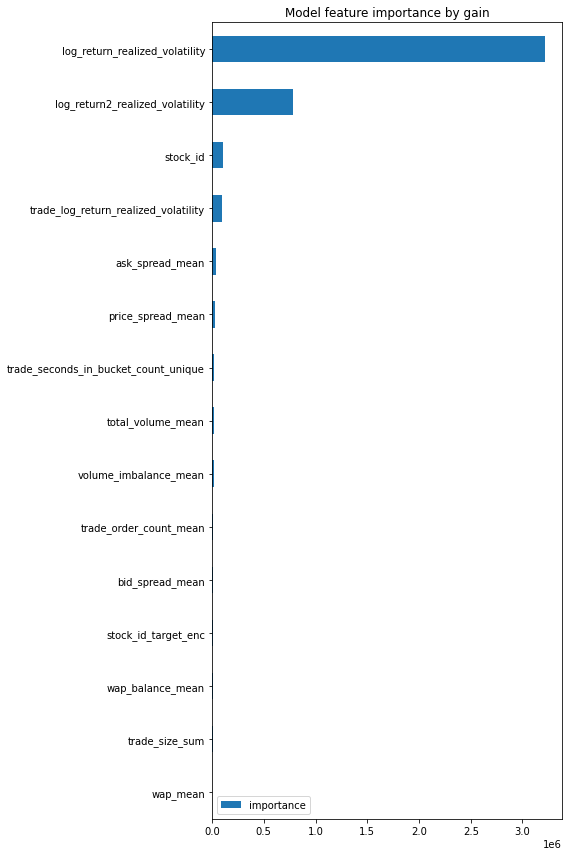

In [24]:
if DO_FEAT_IMP:
    mean_gain_df = calc_mean_importance(gain_importance_list)
    plot_importance(mean_gain_df, title='Model feature importance by gain')
    mean_gain_df = mean_gain_df.reset_index().rename(columns={'index': 'feature_names'})
    mean_gain_df.to_csv('gain_importance_mean.csv', index=False)

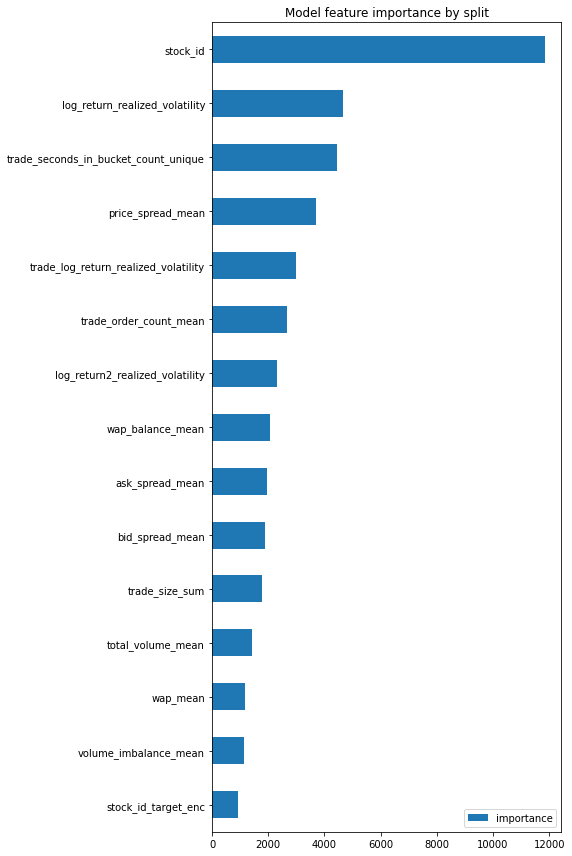

In [25]:
if DO_FEAT_IMP:
    mean_split_df = calc_mean_importance(split_importance_list)
    plot_importance(mean_split_df, title='Model feature importance by split')
    mean_split_df = mean_split_df.reset_index().rename(columns={'index': 'feature_names'})
    mean_split_df.to_csv('split_importance_mean.csv', index=False)

# 以下 試行錯誤欄

## book側

In [26]:
df = pd.read_parquet(data_dir + "book_train.parquet/stock_id=0")
df_ids = df.time_id.unique()
df_ids

array([    5,    11,    16, ..., 32758, 32763, 32767], dtype=int16)

In [27]:
book_time_id_number = 5

In [28]:
df['wap'] = calc_wap(df)
df['wap2'] = calc_wap2(df)

df['log_return'] = df.groupby('time_id')['wap'].apply(log_return)
df[df["time_id"] == book_time_id_number]

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,wap,wap2,log_return
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100,1.001434,1.001390,NaN
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100,1.001448,1.001390,0.000014
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100,1.001448,1.001391,0.000000
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100,1.001443,1.001391,-0.000005
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100,1.001443,1.001391,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,5,585,1.003129,1.003749,1.003025,1.003801,100,3,26,3,1.003731,1.003721,0.000245
298,5,586,1.003129,1.003749,1.002612,1.003801,100,3,2,3,1.003731,1.003087,0.000000
299,5,587,1.003129,1.003749,1.003025,1.003801,100,3,26,3,1.003731,1.003721,0.000000
300,5,588,1.003129,1.003749,1.002612,1.003801,100,3,2,3,1.003731,1.003087,0.000000


<AxesSubplot:>

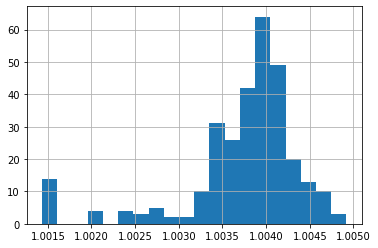

In [29]:
df[df['time_id']== book_time_id_number]["wap"].hist(bins=20)

<AxesSubplot:>

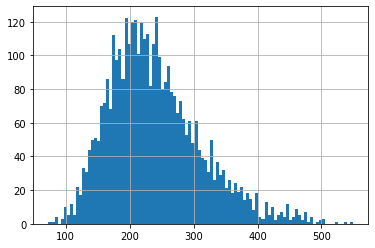

In [30]:
df_book_time_id_count = df.groupby('time_id').count()
df_book_time_id_count["wap"].hist(bins=100)

In [31]:
min(df_book_time_id_count["wap"])

73

## ボインジャーバンド
ボリンジャーバンドは統計学を使って作られていて、大まかにいうと、高い確率で＋2σ(標準偏差)と－2σのラインの間で価格は動くだろうという予測をもとに将来の価格の動きを予測するために使う指標。  
なので、±2σの差が大きいほど値動きが激しいので、次の予想に使えるのではないかと思った。  
  
  
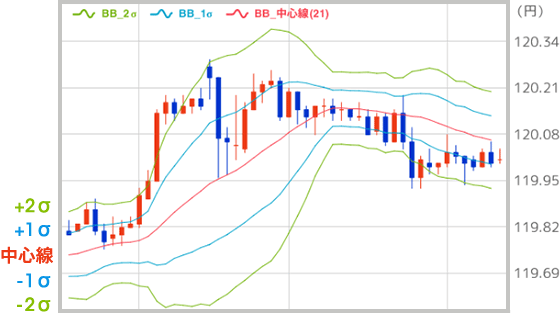!


In [32]:
df['mean'] = df["wap"].rolling(window=20).mean()
df['std'] = df["wap"].rolling(window=20).std()
df['wap_bol_upper'] = df['mean'] + (df['std'] * 2)
df['wap_bol_lower'] = df['mean'] - (df['std'] * 2)
df['wap_bol_balance'] = df['wap_bol_upper'] - df['wap_bol_lower']
df[df["time_id"] == book_time_id_number]

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,wap,wap2,log_return,mean,std,wap_bol_upper,wap_bol_lower,wap_bol_balance
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100,1.001434,1.001390,NaN,NaN,NaN,NaN,NaN,NaN
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100,1.001448,1.001390,0.000014,NaN,NaN,NaN,NaN,NaN
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100,1.001448,1.001391,0.000000,NaN,NaN,NaN,NaN,NaN
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100,1.001443,1.001391,-0.000005,NaN,NaN,NaN,NaN,NaN
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100,1.001443,1.001391,0.000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,5,585,1.003129,1.003749,1.003025,1.003801,100,3,26,3,1.003731,1.003721,0.000245,1.002914,0.000573,1.004060,1.001768,0.002292
298,5,586,1.003129,1.003749,1.002612,1.003801,100,3,2,3,1.003731,1.003087,0.000000,1.002928,0.000590,1.004108,1.001748,0.002360
299,5,587,1.003129,1.003749,1.003025,1.003801,100,3,26,3,1.003731,1.003721,0.000000,1.002948,0.000611,1.004169,1.001727,0.002443
300,5,588,1.003129,1.003749,1.002612,1.003801,100,3,2,3,1.003731,1.003087,0.000000,1.002996,0.000633,1.004263,1.001729,0.002534


### ボインジャーバンドの差の合計

## 自己相関のグラフ
自己相関とは、時系列データを分析するツールの一つで、例えば、ある日のデータと次の日のデータ、またある日のデータとその次の日のデータという組み合わせを作ったうえでの相関係数を計算したもの。  

**【参考】**
* https://qiita.com/hcpmiyuki/items/b1783956dee20c6d4700

In [33]:
import statsmodels.api as sm

In [34]:
df.wap = df.wap.astype('float64')
df.wap2 = df.wap2.astype('float64')

CPU times: user 265 ms, sys: 222 ms, total: 486 ms
Wall time: 156 ms


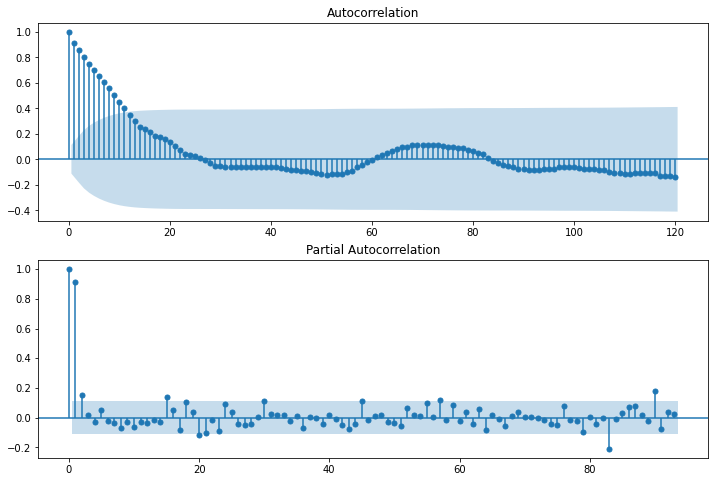

In [35]:
%%time
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df[df["time_id"] == book_time_id_number]['wap'], lags=120, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df[df["time_id"] == book_time_id_number]['wap'],lags=93, ax=ax2)

### わかったこと
* time_idごとで相関がバラバラ
* time_idごとで個数がバラバラ

### データをトレンドと季節成分に分解

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


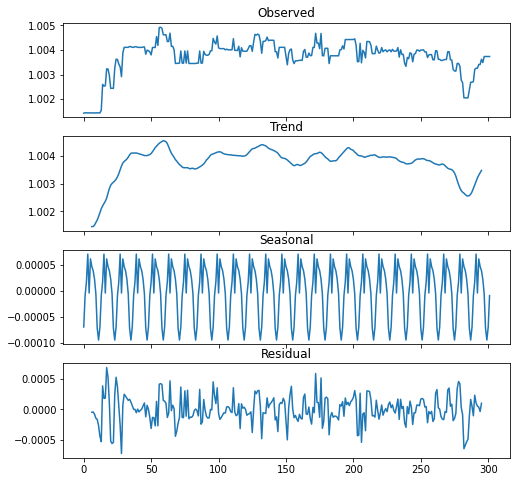

In [36]:
seasonal_decompose_res = sm.tsa.seasonal_decompose(df[df["time_id"] == book_time_id_number]['wap'], freq=12)

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 8), sharex=True)
# 原系列
axes[0].set_title('Observed')
axes[0].plot(seasonal_decompose_res.observed)
# 傾向変動
axes[1].set_title('Trend')
axes[1].plot(seasonal_decompose_res.trend)
# 季節変動
axes[2].set_title('Seasonal')
axes[2].plot(seasonal_decompose_res.seasonal)
# 残差 (不規則変動 = 誤差変動 + 特異的変動)
axes[3].set_title('Residual')
axes[3].plot(seasonal_decompose_res.resid)

# グラフを表示する
plt.show()

観測データ(生データ) = トレンド成分 + 季節成分 + 残差  
トレンド成分で、動きが大きいと、次の予想に繋がるか？

## Trade 側

In [37]:
df_trade = pd.read_parquet(data_dir + "trade_train.parquet/stock_id=0")
df_trade_ids = df_trade.time_id.unique()
print(df_trade_ids)

[    5    11    16 ... 32758 32763 32767]


In [38]:
trade_time_id_number = 32758 

In [39]:
df_trade[df_trade["time_id"] == trade_time_id_number ].describe()

,time_id,seconds_in_bucket,price,size,order_count
count,36.0,36.000000,36.000000,36.000000,36.000000
mean,32758.0,304.305556,0.999633,118.055556,3.500000
std,0.0,167.294918,0.000695,141.328583,3.660601
min,32758.0,0.000000,0.998438,1.000000,1.000000
25%,32758.0,151.000000,0.999037,12.750000,1.000000
50%,32758.0,353.500000,0.999504,100.000000,2.000000
75%,32758.0,418.000000,1.000353,173.750000,4.250000
max,32758.0,579.000000,1.000705,601.000000,18.000000


CPU times: user 81.5 ms, sys: 45.9 ms, total: 127 ms
Wall time: 61.2 ms


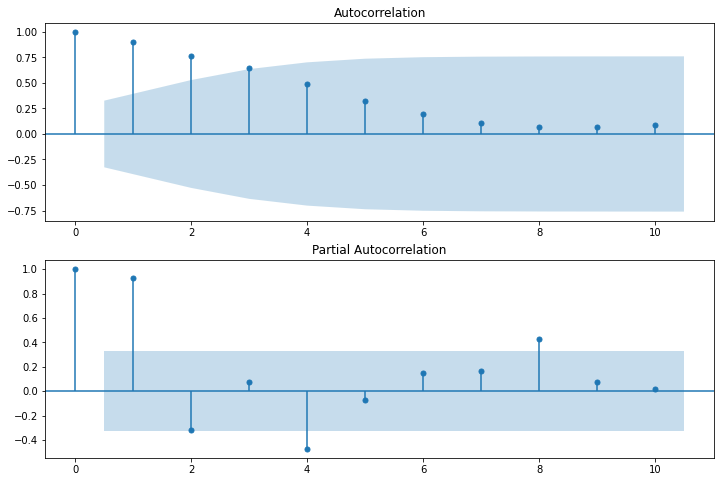

In [40]:
%%time
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_trade[df_trade["time_id"] == trade_time_id_number]['price'], lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_trade[df_trade["time_id"] == trade_time_id_number]['price'],lags=10, ax=ax2)

array([[<AxesSubplot:title={'center':'seconds_in_bucket'}>,
        <AxesSubplot:title={'center':'price'}>],
       [<AxesSubplot:title={'center':'size'}>,
        <AxesSubplot:title={'center':'order_count'}>]], dtype=object)

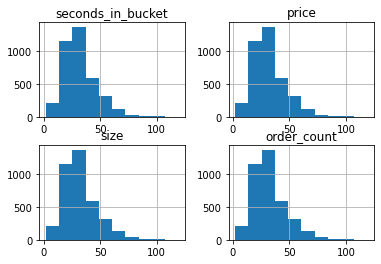

In [41]:
df_time_id_count = df_trade.groupby('time_id').count()
df_time_id_count.hist()

# 気づいたこと
trade側でもtime_idごとのデータ数は必ず固定ということはない。

➡売買で決まるから変則的か？

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


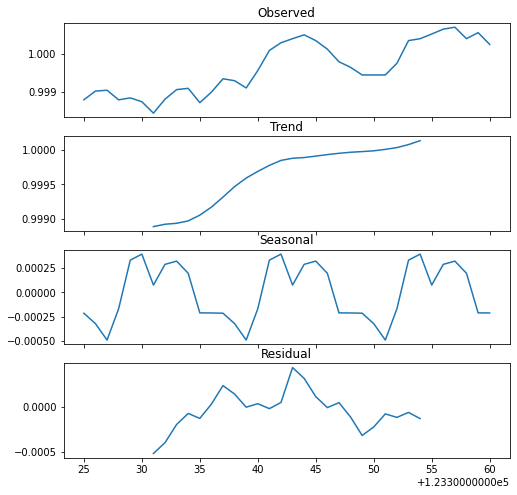

In [42]:
seasonal_decompose_res = sm.tsa.seasonal_decompose(df_trade[df_trade["time_id"] == trade_time_id_number]['price'], freq=12)

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 8), sharex=True)
# 原系列
axes[0].set_title('Observed')
axes[0].plot(seasonal_decompose_res.observed)
# 傾向変動
axes[1].set_title('Trend')
axes[1].plot(seasonal_decompose_res.trend)
# 季節変動
axes[2].set_title('Seasonal')
axes[2].plot(seasonal_decompose_res.seasonal)
# 残差 (不規則変動 = 誤差変動 + 特異的変動)
axes[3].set_title('Residual')
axes[3].plot(seasonal_decompose_res.resid)

# グラフを表示する
plt.show()